In [1]:
import scipy.io as sio
GOOGLE_COLAB = True
if GOOGLE_COLAB:
    from google.colab import drive, files
    drive.mount('/content/drive')
    data_path = "/content/drive/My Drive/MyDataset/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import cv2
import pickle
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


np.random.seed(5)

%matplotlib inline

In [3]:
DATA_DIR = data_path
TRAIN_DATA_DIR = os.path.join(DATA_DIR, 'train')
VALID_DATA_DIR = os.path.join(DATA_DIR, 'validation')
TEST_DATA_DIR = os.path.join(DATA_DIR, 'test')

In [4]:
IMG_SIZE = 224
CATEGORIES = []

for i in os.listdir(TRAIN_DATA_DIR):
    CATEGORIES.append(i)
    
print(CATEGORIES)

['with_mask', 'without_mask']


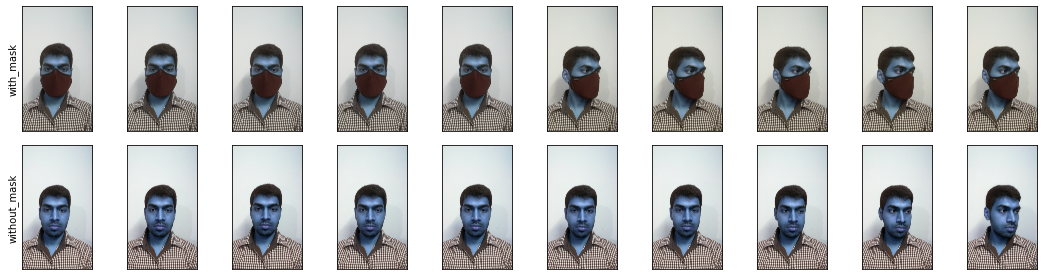

In [5]:
plt.figure(figsize=(15,4))
i=0
for c in CATEGORIES:  
    path = os.path.join(TRAIN_DATA_DIR,c)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img))
        plt.subplot(2,10,i+1)
        plt.imshow(img_array)
        if i%10 == 0:
            plt.ylabel(c)
        plt.xticks([])
        plt.yticks([])
        i += 1
        if i%10 == 0:
            break

plt.tight_layout()        
plt.show() 

In [6]:
training_data = []

for c in CATEGORIES:
    path = os.path.join(TRAIN_DATA_DIR, c) 
    class_num = CATEGORIES.index(c) 
    for img in tqdm(os.listdir(path)):
        try:
            img_array = cv2.imread(os.path.join(path, img))   
            img_resized = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE)) 
            training_data.append([img_resized, class_num]) 
        except WException as e:
            pass
        
print(len(training_data))

100%|██████████| 72/72 [00:07<00:00,  9.04it/s]

193


In [7]:
valid_data = []

for c in CATEGORIES:
    path = os.path.join(VALID_DATA_DIR, c) 
    class_num = CATEGORIES.index(c) 
    for img in tqdm(os.listdir(path)):
        try:
            img_array = cv2.imread(os.path.join(path, img))   
            img_resized = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  
            valid_data.append([img_resized, class_num])
        except WException as e:
            pass
        
print(len(valid_data))

100%|██████████| 5/5 [00:00<00:00,  8.78it/s]

11


In [8]:
test_data = []

for c in CATEGORIES:
    path = os.path.join(TEST_DATA_DIR, c) 
    class_num = CATEGORIES.index(c) 
    for img in tqdm(os.listdir(path)):
        try:
            img_array = cv2.imread(os.path.join(path, img))   
            img_resized = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  
            test_data.append([img_resized, class_num])
        except WException as e:
            pass
        
print(len(test_data))

100%|██████████| 5/5 [00:00<00:00,  7.95it/s]

12


In [9]:
random.shuffle(training_data)
random.shuffle(valid_data)
random.shuffle(test_data)

In [10]:
X_train = []
Y_train = []
# X_train.shape
for img, label in training_data:
    X_train.append(img)
    Y_train.append(label)
    
X_train = np.array(X_train).astype('float32').reshape(-1,IMG_SIZE,IMG_SIZE,3)
Y_train = np.array(Y_train)

print(f"X_train= {X_train.shape} Y_train= {Y_train.shape}")

X_train= (193, 224, 224, 3) Y_train= (193,)


In [11]:
X_valid = []
Y_valid = []

for img, label in valid_data:
    X_valid.append(img)
    Y_valid.append(label)
    
X_valid = np.array(X_valid).astype('float32').reshape(-1,IMG_SIZE,IMG_SIZE,3)
Y_valid = np.array(Y_valid)

print(f"X_valid= {X_valid.shape} Y_valid= {Y_valid.shape}")

X_valid= (11, 224, 224, 3) Y_valid= (11,)


In [12]:
X_test = []
Y_test = []

for features,label in test_data:
    X_test.append(features)
    Y_test.append(label)

X_test = np.array(X_test).astype('float32').reshape(-1, IMG_SIZE, IMG_SIZE, 3)
Y_test = np.array(Y_test)

print(f"X_test= {X_test.shape} Y_test= {Y_test.shape}")

X_test= (12, 224, 224, 3) Y_test= (12,)


In [13]:
np.random.seed(5)

%matplotlib inline

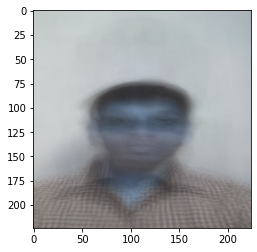

In [14]:
mean_img = np.mean(X_train, axis=0)
plt.imshow(mean_img.astype('uint8'))


In [15]:
X_train_norm, X_valid_norm, X_test_norm = X_train-mean_img, X_valid-mean_img, X_test-mean_img

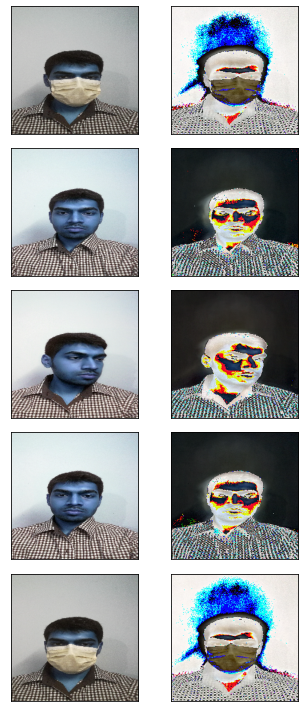

In [16]:
c = 0
plt.figure(figsize=(5,10))
for i in range(5):
    plt.subplot(5,2,c+1)
    plt.imshow(X_train[i].astype('uint8'))
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(5,2,c+2)
    plt.imshow(X_train_norm[i].astype('uint8'))
    plt.xticks([])
    plt.yticks([])

    c += 2
    
plt.tight_layout()
plt.show()

In [17]:
model = keras.Sequential([
    ## input layer
    keras.Input(shape=X_train.shape[1:]),
    
    
    layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), padding='valid'),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
    layers.BatchNormalization(),
    
    layers.Conv2D(filters=256, kernel_size=(11,11), strides=(1,1), padding='valid'),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
    layers.BatchNormalization(),
    
    layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'),
    layers.Activation('relu'),
    layers.BatchNormalization(),
    
    layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'),
    layers.Activation('relu'),
    layers.BatchNormalization(),
    
    layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='valid'),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
    layers.BatchNormalization(),
    
    layers.Flatten(),
    
    layers.Dense(units=4096),
    layers.Activation('relu'),
    layers.Dropout(0.5),
    layers.BatchNormalization(),
    
    layers.Dense(units=4096),
    layers.Activation('relu'),
    layers.Dropout(0.5),
    layers.BatchNormalization(),

    layers.Dense(50),
    layers.Activation('softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 54, 54, 96)        34944     
                                                                 
 activation (Activation)     (None, 54, 54, 96)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 96)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 27, 27, 96)       384       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 17, 17, 256)       2973952   
                                                                 
 activation_1 (Activation)   (None, 17, 17, 256)       0

In [18]:
#Compile the model
model.compile(
    optimizer='adam', 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

In [19]:
#Fit the model for validation
h = model.fit(x=X_train_norm, y=Y_train, epochs=10, validation_data=(X_valid_norm, Y_valid), batch_size=1)

Epoch 1/10
193/193 [==============================] - 9s 29ms/step - loss: 0.9702 - accuracy: 0.5907 - val_loss: nan - val_accuracy: 0.5455
Epoch 2/10
193/193 [==============================] - 5s 27ms/step - loss: 0.7215 - accuracy: 0.5699 - val_loss: nan - val_accuracy: 0.5455
Epoch 3/10
193/193 [==============================] - 5s 27ms/step - loss: 0.7002 - accuracy: 0.6269 - val_loss: nan - val_accuracy: 0.5455
Epoch 4/10
193/193 [==============================] - 5s 27ms/step - loss: 0.6851 - accuracy: 0.5699 - val_loss: nan - val_accuracy: 0.5455
Epoch 5/10
193/193 [==============================] - 5s 27ms/step - loss: 0.6890 - accuracy: 0.6010 - val_loss: nan - val_accuracy: 0.5455
Epoch 6/10
193/193 [==============================] - 5s 26ms/step - loss: 0.6801 - accuracy: 0.6269 - val_loss: nan - val_accuracy: 0.5455
Epoch 7/10
193/193 [==============================] - 5s 27ms/step - loss: 0.6819 - accuracy: 0.6269 - val_loss: nan - val_accuracy: 0.5455
Epoch 8/10
193/193 [

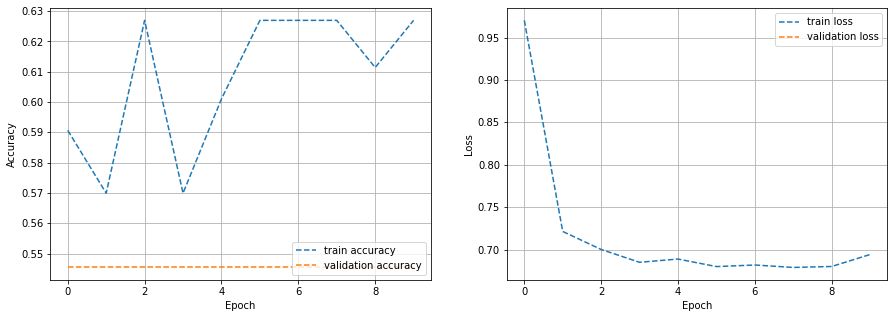

In [20]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(h.history['accuracy'], '--', label='train accuracy')
plt.plot(h.history['val_accuracy'], '--', label = 'validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(h.history['loss'], '--', label='train loss')
plt.plot(h.history['val_loss'], '--', label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend(loc='upper right')

plt.show()

In [21]:
#Check test data accuracy
test_loss, test_acc = model.evaluate(X_test_norm, Y_test)
print('\nTest Accuracy:', test_acc)
print('\nTest Loss:', test_loss)

1/1 [==============================] - 1s 793ms/step - loss: nan - accuracy: 0.5833

Test Accuracy: 0.5833333134651184

Test Loss: nan


In [22]:
model.save('mask_detector.model', save_format = 'h5')